# ARIMA 

http://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from datetime import datetime
import matplotlib.pyplot as plt

# Zadanie
Wczytaj dane "Shampoo Sales Dataset", które opisują miesięczną liczbę sprzedaży szamponu przez okres 3 lat.

In [3]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('data/sales-of-shampoo-over-a-three-ye.csv', header=0, 
                  parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
rng1 = pd.date_range('1901-01-01', periods=len(series), freq='M')
print(series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


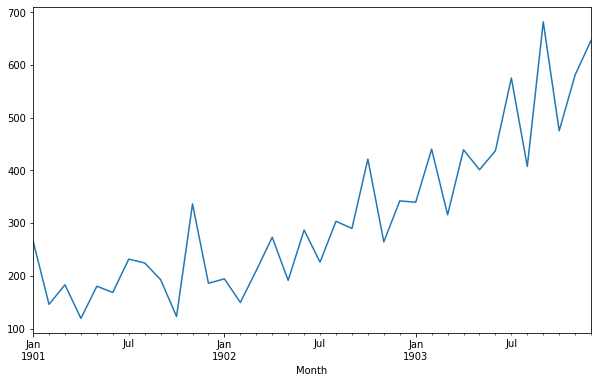

In [4]:
plt.figure(figsize=(10,6));
series.plot()
plt.show()

Po pierwsze, będziemy testowali nasze modele na ostatnim roku. Biorąc pod uwagę dane miesięczne, oznacza to, że 12 ostatnich obserwacji zostanie wykorzystanych jako zbiór testowy.

W celu oceny skuteczności modelu, zastosujemy metodę walidacji walk-forward. Oznacza to, że nauczymy model na danych historycznych. Będziemy prognozować najbliższy punkt i oceniać poziom predykcji. Obserwacja zostanie następnie dodana do zestawu danych uczących i proces powtórzony.


In [5]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [6]:
X = series.values
train, test = X[0:-12], X[-12:]

In [7]:
print(series.index)
rng1 = pd.date_range('1900-12-01', periods=len(X)-12, freq='M').shift(1, freq="D")
rng2 =pd.date_range('1902-12-01', periods=12, freq='M').shift(1, freq="D")
print(rng1)
print(rng2)

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
               '1902-05-01', '1902-06-01', '1902-07-01', '1902-08-01',
               '1902-09-01', '1902-10-01', '1902-11-01', '1902-12-01',
               '1903-01-01', '1903-02-01', '1903-03-01', '1903-04-01',
               '1903-05-01', '1903-06-01', '1903-07-01', '1903-08-01',
               '1903-09-01', '1903-10-01', '1903-11-01', '1903-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)
DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01', '1901-11-01', '1901-12-01',
               '1902-01-01', '1902-02-01', '1902-03-01', '1902-04-01',
             

In [8]:
#trainS=pd.Series(np.stack(predictions,1)[0], index=data['1955-05-01':'1960-05-01'].index)
trainS=pd.Series(train, index=rng1)
testS=pd.Series(test,index=rng2)

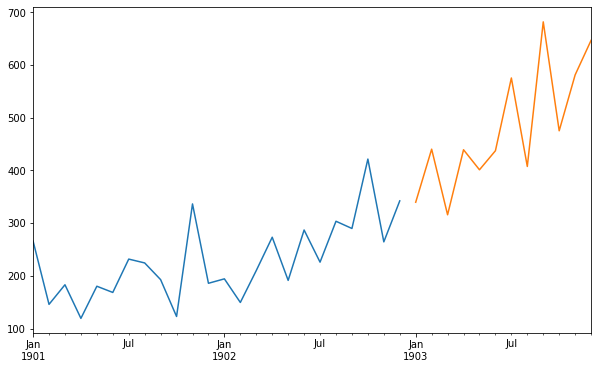

In [9]:
plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
plt.show()

# Zadanie
Naucz modela ARIMA(4,1,0)

Test RMSE: 84.832


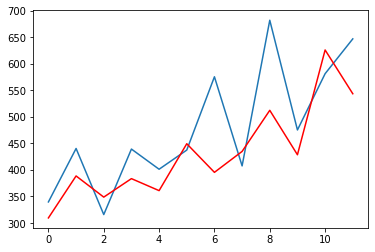

In [10]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [11]:
predictions

[array([309.59066404]),
 array([388.64159473]),
 array([348.77806403]),
 array([383.60199319]),
 array([360.99200969]),
 array([449.3421064]),
 array([395.44930114]),
 array([434.86484322]),
 array([512.3020267]),
 array([428.59745117]),
 array([625.99351302]),
 array([543.53894907])]

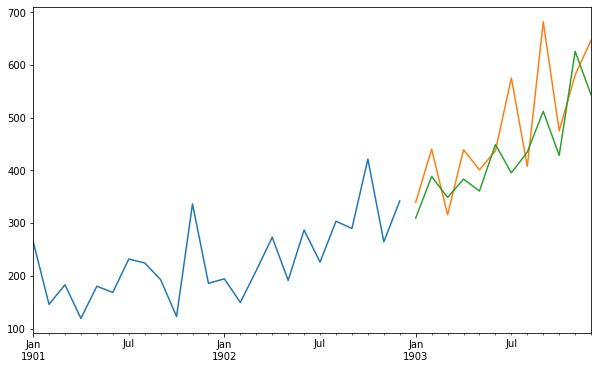

In [12]:
pre=pd.Series(np.stack(predictions,1)[0], index=testS.index)

plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
pre.plot()
plt.show()

# Zadanie
Napisz procedurę Cross Validation dla modelu ARIMA

In [13]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [16]:
# evaluate parameters
p_values = [0, 1, 2, 4]#, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=52425.268
ARIMA(0, 0, 1) MSE=38145.267
ARIMA(0, 0, 2) MSE=23989.525
ARIMA(0, 1, 0) MSE=18003.173
ARIMA(0, 1, 1) MSE=9558.374
ARIMA(0, 1, 2) MSE=6306.505
ARIMA(0, 2, 0) MSE=67339.810
ARIMA(0, 2, 1) MSE=18323.282
ARIMA(1, 0, 0) MSE=23113.000
ARIMA(1, 0, 2) MSE=7291.622
ARIMA(1, 1, 0) MSE=7121.372
ARIMA(1, 1, 1) MSE=7003.683
ARIMA(1, 2, 0) MSE=18608.008
ARIMA(2, 0, 0) MSE=10176.443
ARIMA(2, 1, 0) MSE=5689.928
ARIMA(2, 1, 1) MSE=7759.701
ARIMA(2, 2, 0) MSE=9860.939
ARIMA(4, 0, 0) MSE=7380.580
ARIMA(4, 1, 0) MSE=6649.594
ARIMA(4, 1, 1) MSE=6796.249
ARIMA(4, 2, 0) MSE=7596.325
ARIMA(4, 2, 1) MSE=4694.870
Best ARIMA(4, 2, 1) MSE=4694.870


# Zadanie
Wykonaj predykcję dla najlepszego modelu.

Test RMSE: 71.969


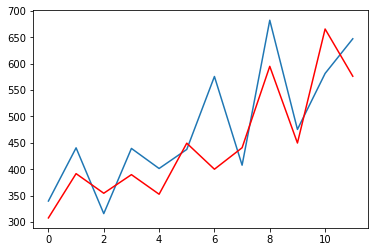

In [16]:
history = [x for x in train]
predictions = list()
y_n_p = X[-13:-1]
# walk-forward validation
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(6,1,1))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [18]:
X

array([266. , 145.9, 183.1, 119.3, 180.3, 168.5, 231.8, 224.5, 192.8,
       122.9, 336.5, 185.9, 194.3, 149.5, 210.1, 273.3, 191.4, 287. ,
       226. , 303.6, 289.9, 421.6, 264.5, 342.3, 339.7, 440.4, 315.9,
       439.3, 401.3, 437.4, 575.5, 407.6, 682. , 475.3, 581.3, 646.9])

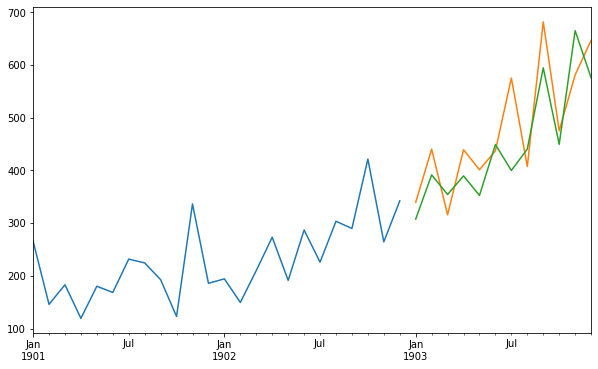

In [18]:
pre=pd.Series(np.stack(predictions,1)[0], index=testS.index)

plt.figure(figsize=(10,6));
trainS.plot()
testS.plot()
pre.plot()
plt.show()

# Zadanie
Znajdź najlepszy model ARIMA dla danych:

In [19]:
series = pd.read_csv('data/sunspots.csv', index_col = 'YEAR', squeeze = True)
series.head()

YEAR
1700     5.0
1701    11.0
1702    16.0
1703    23.0
1704    36.0
Name: SUNACTIVITY, dtype: float64

In [28]:
p_values = [0, 1, 2, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=2454.159
ARIMA(0, 0, 1) MSE=1004.256
ARIMA(0, 1, 0) MSE=844.153
ARIMA(0, 1, 1) MSE=636.472
ARIMA(0, 1, 2) MSE=553.405
ARIMA(0, 2, 0) MSE=746.438
ARIMA(0, 2, 1) MSE=749.281
ARIMA(0, 2, 2) MSE=645.181
ARIMA(1, 0, 0) MSE=777.619
ARIMA(1, 0, 1) MSE=562.415
ARIMA(1, 0, 2) MSE=460.745
ARIMA(1, 1, 0) MSE=586.400
ARIMA(1, 1, 1) MSE=585.980
ARIMA(1, 2, 0) MSE=748.628
ARIMA(2, 0, 0) MSE=396.579
ARIMA(2, 0, 1) MSE=387.854
ARIMA(2, 0, 2) MSE=385.661
ARIMA(2, 1, 0) MSE=575.942
ARIMA(2, 2, 0) MSE=771.160
ARIMA(4, 0, 0) MSE=385.389
ARIMA(4, 0, 1) MSE=352.816
ARIMA(4, 0, 2) MSE=307.595
ARIMA(4, 1, 0) MSE=459.393
ARIMA(4, 2, 0) MSE=716.572
ARIMA(5, 0, 0) MSE=387.553
ARIMA(5, 0, 1) MSE=345.461
ARIMA(5, 0, 2) MSE=332.102
ARIMA(5, 1, 0) MSE=417.509
ARIMA(5, 1, 1) MSE=322.531
ARIMA(5, 1, 2) MSE=302.077
ARIMA(5, 2, 0) MSE=689.099
Best ARIMA(5, 1, 2) MSE=302.077


Test RMSE: 17.520
Naive RMSE: 28.998


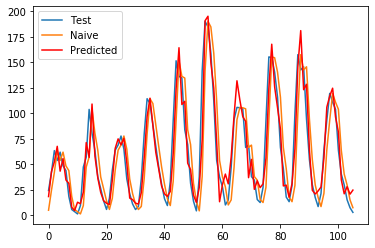

In [25]:
train_size = int(len(series.values) * 0.66)
train, test = series.values[0:train_size], series.values[train_size:]
test1 = series.values[train_size-1:-1]
history = [x for x in train]
predictions = list()
# walk-forward validation

for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(6,1,2))
    model_fit = model.fit()
    # one step forecast
    yhat = model_fit.forecast()[0]
    # store forecast and ob
    predictions.append(yhat)
    history.append(test[t])

# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
rmse_naive = sqrt(mean_squared_error(test, test1))
print('Test RMSE: %.3f' % rmse)
print('Naive RMSE: %.3f' % rmse_naive)
# plot forecasts against actual outcomes
plt.plot(test, label = 'Test')
plt.plot(test1, label = 'Naive')
plt.plot(predictions, color='red', label = 'Predicted')
plt.legend()
plt.show()